# generating snapshots of creation event (Fenton-Karma model)
Tim Tyree<br>
4.23.2024

In [1]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import skimage as sk
from skimage import measure, filters
from numba import njit, jit, vectorize
from PIL import Image
import imageio
#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
# #load the libraries
from lib import *
#use cuda via numba
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
from numba.typed import List
import shutil
from lib.measure.comp_tips_safely import get_comp_tips
from lib.viewer.DomainPlot import SaveTipsAndColoredContours
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


# define module

In [85]:
def time_evolve_domain_fk_cu(txt,iterations,time_step_kernel,drv,printing=True):
    """
    Example Usage:
txt_next = time_evolve_domain_fk_cu(txt,iterations,time_step_kernel,drv,printing=True)
    """
    #define the initial conditions
    u_initial=txt[...,0].copy()
    v_initial=txt[...,1].copy()
    w_initial=txt[...,2].copy()
    #don't allocate memory many times for the same task!
    #allocate GPU memory for voltage scalar field
    u_old = drv.mem_alloc(u_initial.nbytes)
    u_new = drv.mem_alloc(u_initial.nbytes)
    #allocate GPU memory for v and w auxiliary fields
    v_old = drv.mem_alloc(v_initial.nbytes)
    v_new = drv.mem_alloc(v_initial.nbytes)
    w_old = drv.mem_alloc(w_initial.nbytes)
    w_new = drv.mem_alloc(w_initial.nbytes)
#     # #create events for measuring performance
#     if printing:
#         start_timer = drv.Event()
#         end_timer = drv.Event()
    #move the data to the GPU
    drv.memcpy_htod(u_old, u_initial)
    drv.memcpy_htod(u_new, u_initial)
    drv.memcpy_htod(v_old, v_initial)
    drv.memcpy_htod(v_new, v_initial)
    drv.memcpy_htod(w_old, w_initial)
    drv.memcpy_htod(w_new, w_initial)

    #call the GPU kernel 2*iterations times and measure performance
    context.synchronize()
#     if printing:
#         start_timer.record()
    for step in range(iterations):
        time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
        time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
        #update progressbar
        if printing and step%50==0:
            printProgressBar(step + 1, iterations, prefix = f'Progress:', suffix = f'Complete', length = 50)
    if printing:
        printProgressBar(iterations, iterations, prefix = f'Progress:', suffix = f'Complete', length = 50)
    # end_timer.record()
    context.synchronize()
#     if printing:
#         runtime = end_timer.time_since(start_timer)
#         print(f"{iterations*2} time steps took {runtime:.0f} ms.")

    #copy the result from the GPU to Python for plotting
    gpu_result_u = np.zeros_like(u_initial)
    drv.memcpy_dtoh(gpu_result_u, u_old)
    gpu_result_v = np.zeros_like(v_initial)
    drv.memcpy_dtoh(gpu_result_v, v_old)
    gpu_result_w = np.zeros_like(w_initial)
    drv.memcpy_dtoh(gpu_result_w, w_old)

    #stack txt
    return np.stack((gpu_result_u,gpu_result_v,gpu_result_w),axis=-1)

# load my gpu accelerated one step method

In [2]:
#load parameters for parameter set 8 for the Fenton-Karma Model
kwargs = read_parameters_from_json('lib/model/param_set_8.json')
print(F"default parameters:")
print_dict(kwargs)

default parameters:
diffCoef=0.0005
C_m=1.0
tau_pv=13.03
tau_v2=19.6
tau_v1=1250
tau_pw=800
tau_mw=40
tau_d=0.45
tau_0=12.5
tau_r=33.25
tau_si=29
K=10
V_sic=0.85
V_c=0.13
V_v=0.04


In [4]:
from lib.model.minimal_model_cuda import *
#the following might be needed for the kernel_autotuner.
drv.init()

20000 time steps took 1527 ms.


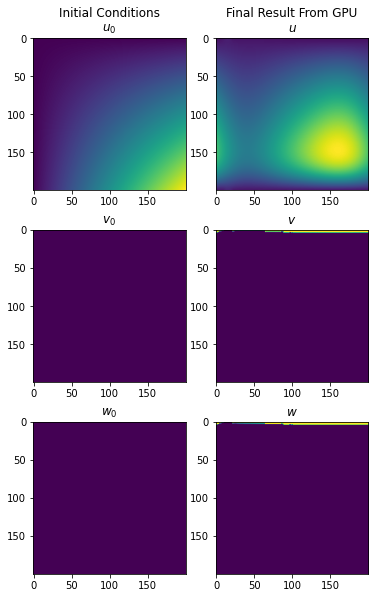

In [11]:
# from lib.model.minimal_model_cuda import *
#the following might be needed for the kernel_autotuner.
# drv.init()

#define how resources are used
width  = 200
height = 200
block_size_x=10
block_size_y=10
threads = (block_size_x,block_size_y,1)
grid = (int(width/block_size_x), int(height/block_size_y), 1)
block_size_string = f"#define block_size_x {block_size_x}\n#define block_size_y {block_size_y}\n"

#set spatial discretization
DX=0.025 #cm
# DY=0.025
DT=0.025 #ms

#initialize PyCuda and get compute capability needed for compilation
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

#load parameters for parameter set 8 for the Fenton-Karma Model
# kwargs = read_parameters_from_json('lib/model/param_set_8.json')
kwargs['width']=width
kwargs['height']=height
kwargs['DX']=DX
# kwargs['DT']=DT
# kwargs['DY']=DY

#define the initial conditions
Vin  = np.array([256*x*(y+1) for x in range(width) for y in range(height)]).reshape((width,height))

u_initial = Vin.astype(np.float64)
#initialize auxiliary textures to zero
v_initial = np.zeros_like(u_initial)
w_initial = np.zeros_like(u_initial)

#don't allocate memory many times for the same task!
#allocate GPU memory for voltage scalar field
u_old = drv.mem_alloc(u_initial.nbytes)
u_new = drv.mem_alloc(u_initial.nbytes)

#allocate GPU memory for v and w auxiliary fields
v_old = drv.mem_alloc(v_initial.nbytes)
v_new = drv.mem_alloc(v_initial.nbytes)
w_old = drv.mem_alloc(w_initial.nbytes)
w_new = drv.mem_alloc(w_initial.nbytes)

# explicit time integration up to 5 seconds in steps of size 0.025 ms
kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)
iterations = 10**4

#setup thread block dimensions and compile the kernel
mod = SourceModule(block_size_string+kernel_string)
time_step_kernel = mod.get_function("time_step_kernel")

#create events for measuring performance
start = drv.Event()
end = drv.Event()

#move the data to the GPU
drv.memcpy_htod(u_old, u_initial)
drv.memcpy_htod(u_new, u_initial)
drv.memcpy_htod(v_old, v_initial)
drv.memcpy_htod(v_new, v_initial)
drv.memcpy_htod(w_old, w_initial)
drv.memcpy_htod(w_new, w_initial)

#call the GPU kernel 2*iterations times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
    time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
end.record()
context.synchronize()
runtime = end.time_since(start)
print(f"{iterations*2} time steps took {runtime:.0f} ms.")

#copy the result from the GPU to Python for plotting
gpu_result_u = np.zeros_like(u_initial)
drv.memcpy_dtoh(gpu_result_u, u_old)
gpu_result_v = np.zeros_like(v_initial)
drv.memcpy_dtoh(gpu_result_v, v_old)
gpu_result_w = np.zeros_like(w_initial)
drv.memcpy_dtoh(gpu_result_w, w_old)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(6,10))
ax1.imshow(u_initial)
ax1.set_title("Initial Conditions\n$u_0$")
ax2.imshow(gpu_result_u)
ax2.set_title("Final Result From GPU\n$u$")

ax3.imshow(v_initial)
ax3.set_title("$v_0$")
ax4.imshow(gpu_result_v)
ax4.set_title("$v$")

ax5.imshow(w_initial)
ax5.set_title("$w_0$")
ax6.imshow(gpu_result_w)
ax6.set_title("$w$")
plt.show();

In [8]:
print (kernel_string)


// primary model parameters
#define width  200
#define height 200
#define h      0.025
#define C_m    1.0
#define tau_pv 13.03
#define tau_v1 1250.0
#define tau_v2 19.6
#define tau_pw 800.0
#define tau_mw 40.0
#define tau_d  0.45
#define tau_0  12.5
#define tau_r  33.25
#define tau_si 29.0
#define K      10.0
#define V_sic  0.85
#define V_c    0.13
#define V_v    0.04

// auxiliary model parameters
#define nx width
#define ny height
#define dcoef 0.80000000

// periodic boundary conditions
__device__ int _pbc ( int q, int wid ) {
    if (q >= wid) {
        q = 0;
    }
    if (q < 0) {
        q = wid-1;
    }
    return q;
}

// heaviside step function
__device__ double step(double thresh, double x)
{
    return x >= thresh;
}

// main computation kernel/face shader
__global__ void time_step_kernel(double *u_new, double *u, double *v_new, double *v, double *w_new, double *w) {
    int x = blockIdx.x * block_size_x + threadIdx.x;
    int y = blockIdx.y * block_size_y + threadIdx.y;
 

# load initial conditions that contain spiral tips

In [71]:
# load an initial conditions and integrate forward 100ms
printing=True
tf=100. #ms
iterations = int(np.around(tf/DT))
# ic_folder='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-in/'
ic_folder='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/'
# ic_fn='ic200x200.3.80.npz'
# ic_fn='ic200x200.2.80.npz'

ic_fn_lst=["ic200x200.0.0.npz",   "ic200x200.0.59.npz",  "ic200x200.1.34.npz",  "ic200x200.2.0.npz",   "ic200x200.2.59.npz",  "ic200x200.3.34.npz",
"ic200x200.0.10.npz",  "ic200x200.0.5.npz",   "ic200x200.1.35.npz",  "ic200x200.2.10.npz",  "ic200x200.2.5.npz",   "ic200x200.3.35.npz"]

for ic_fn in ic_fn_lst:
    ic_dir=os.path.join(ic_folder,ic_fn)
    if printing:
        print(f"ic_dir='{ic_dir}'")
    #load ic and verify that it contains spiral tips
    txt=load_buffer(ic_dir).astype(np.float64)

ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.0.0.npz'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.0.59.npz'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.1.34.npz'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.2.0.npz'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.2.59.npz'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.3.34.npz'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.0.10.npz'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.0.5.npz'
ic_dir='/home/timothytyree/Document

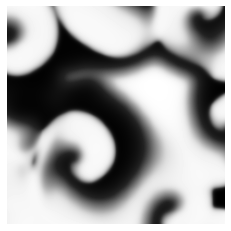

In [72]:
plt.imshow(txt[...,0],cmap='gray')
plt.axis('off')
plt.show()

In [70]:
t=0

In [73]:
# iterations = 67
if printing:
    print(f"forward integrating to tf={tf:.3f} ms (iterations={iterations})...")

forward integrating to tf=100.000 ms (iterations=4000)...


In [74]:
#define the initial conditions
u_initial=txt[...,0].copy()
v_initial=txt[...,1].copy()
w_initial=txt[...,2].copy()

#don't allocate memory many times for the same task!
#allocate GPU memory for voltage scalar field
u_old = drv.mem_alloc(u_initial.nbytes)
u_new = drv.mem_alloc(u_initial.nbytes)
#allocate GPU memory for v and w auxiliary fields
v_old = drv.mem_alloc(v_initial.nbytes)
v_new = drv.mem_alloc(v_initial.nbytes)
w_old = drv.mem_alloc(w_initial.nbytes)
w_new = drv.mem_alloc(w_initial.nbytes)

# explicit time integration up to 5 seconds in steps of size 0.025 ms
kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)

#setup thread block dimensions and compile the kernel
mod = SourceModule(block_size_string+kernel_string)
time_step_kernel = mod.get_function("time_step_kernel")

# #create events for measuring performance
# start_timer = drv.Event()
# end_timer = drv.Event()

#move the data to the GPU
drv.memcpy_htod(u_old, u_initial)
drv.memcpy_htod(u_new, u_initial)
drv.memcpy_htod(v_old, v_initial)
drv.memcpy_htod(v_new, v_initial)
drv.memcpy_htod(w_old, w_initial)
drv.memcpy_htod(w_new, w_initial)

#call the GPU kernel 2*iterations times and measure performance
context.synchronize()
# start_timer.record()
for step in range(iterations):
    time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
    time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
    #update progressbar
    if printing and step%50==0:
        printProgressBar(step + 1, iterations, prefix = f'Progress:', suffix = f'Complete', length = 50)
if printing:
    printProgressBar(iterations, iterations, prefix = f'Progress:', suffix = f'Complete', length = 50)
# end_timer.record()
context.synchronize()
# runtime = end_timer.time_since(start_timer)
print(f"{iterations*2} time steps took {runtime:.0f} ms.")

#copy the result from the GPU to Python for plotting
gpu_result_u = np.zeros_like(u_initial)
drv.memcpy_dtoh(gpu_result_u, u_old)
gpu_result_v = np.zeros_like(v_initial)
drv.memcpy_dtoh(gpu_result_v, v_old)
gpu_result_w = np.zeros_like(w_initial)
drv.memcpy_dtoh(gpu_result_w, w_old)

#stack txt
txt=np.stack((gpu_result_u,gpu_result_v,gpu_result_w),axis=-1)

8000 time steps took 1527 ms.████████████████████████████████| 100.0% Complete


In [75]:
#record final time as new time
t=tf
#cache txt for initialization
txt_init=txt.copy()

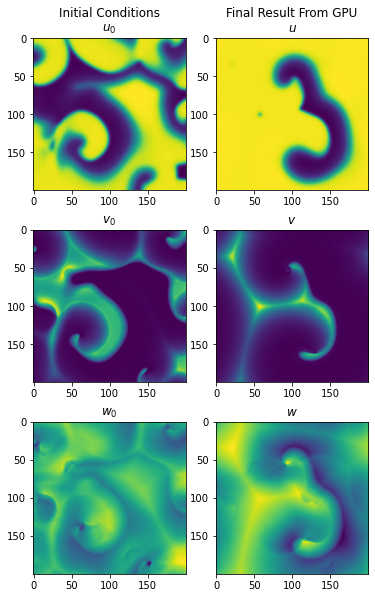

In [76]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(6,10))
ax1.imshow(u_initial)
ax1.set_title("Initial Conditions\n$u_0$")
ax2.imshow(gpu_result_u)
ax2.set_title("Final Result From GPU\n$u$")
ax3.imshow(v_initial)
ax3.set_title("$v_0$")
ax4.imshow(gpu_result_v)
ax4.set_title("$v$")
ax5.imshow(w_initial)
ax5.set_title("$w_0$")
ax6.imshow(gpu_result_w)
ax6.set_title("$w$")
plt.show()

In [77]:
#init methods for instantaneous spiral tip detection
diffCoef=kwargs['diffCoef']
dsdpixel=kwargs['DX']
get_time_step_fk,one_step_fk=recall_flow_map_fk(nb_dir=nb_dir,diffCoef=diffCoef,width=width,height=height,dsdpixel=dsdpixel)
# one_step_luo_rudy,comp_distance,comp_dict_tips=init_methods(nb_dir=nb_dir,width=width,height=height,ds=DX,dt=DT,V_threshold=0.4,jump_threshold=40)
# V_threshold=-60
V_threshold=0.4
compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)

param_fn is param_set_8.json.


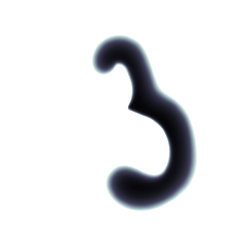

In [78]:
plt.imshow(txt[...,0],cmap='bone',vmin=0,vmax=0.5)
plt.axis('off')
plt.show()

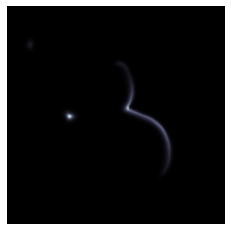

In [79]:
#compute flow map
zero_txt=np.zeros_like(txt)
dtxt_dt=zero_txt.copy()
get_time_step_fk(txt, dtxt_dt)
plt.imshow(dtxt_dt[...,0],cmap='bone',vmin=0,vmax=0.5)
plt.axis('off')
plt.show()

In [80]:
#compute spiral tip locations and verify that they look reasonable
#compute flow map
dtxt_dt=zero_txt.copy()
get_time_step_fk(txt, dtxt_dt)
img=txt[...,0]
dimgdt=dtxt_dt[...,0]
#compute spiral tip locations
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
print_dict(dict_out)

t=100.0
n=2
x=[97.8414870296936, 136.93224109137736]
y=[55.93985082968975, 154.80154917134772]
grad_ux=[1.109791290060852, 0.2960104825605475]
grad_uy=[0.808261901973665, 1.6230833230945594]
grad_vx=[0.15158024445072374, 1.4668210365386904]
grad_vy=[2.4865878158686607, 0.5878340355821113]


In [91]:
n_init =  dict_out['n']

In [81]:
assert dict_out['n']>0
img_prev=txt[...,0].copy()

In [90]:
iterations

160

In [87]:
#DONE: time evolve by 4 ms
# iterations = int(np.around(4/DT))
iterations = int(np.around(4/DT))
txt_next = time_evolve_domain_fk_cu(txt,iterations,time_step_kernel,drv,printing=True)
txt_next.shape,txt_next.max()

((200, 200, 3), 1.0186442991310243)

In [88]:
#DONE: compare img to img_prev to detect spiral tips
img=txt_next[...,0].copy()
dict_out=compute_all_spiral_tips(t,img,img_prev,level1=V_threshold,level2=V_threshold)#,width=width,height=height)
print_dict(dict_out)

t=100.0
n=2
x=[98.66268267724801, 139.23895722072638]
y=[54.8095721445133, 153.99582916219163]
grad_ux=[1.2931828863739216, 0.20329756954800762]
grad_uy=[0.47444132409328876, 1.7247167186702097]
grad_vx=[1.0921666262397338, 0.6810750560926836]
grad_vy=[0.8349092795475721, 1.2906976946668132]


In [95]:
txt_init = txt_next.copy()

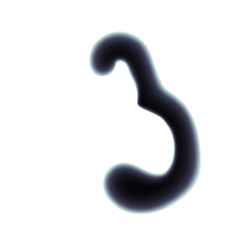

In [89]:
plt.imshow(img,cmap='bone',vmin=0,vmax=0.5)
# plt.imshow(img_prev,cmap='bone',vmin=0,vmax=0.5)
plt.axis('off')
plt.show()

In [96]:
t_init = tf+4

In [98]:
#TODO: iterate over ibid to generate number of tips as a function of time
#reset time
txt = txt_init.copy()
img = txt[...,0].copy()
t = float(t_init)
n = int(n_init)
# inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)

printEnd='\r'
tmax=1000
printing=True
t_lst=[]
n_lst=[]
while t<tmax and n>0:
    img_prev = img
#     for step in range(nsteps_per_DT):
#         one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
#         t+=dt
    txt = time_evolve_domain_fk_cu(txt,iterations,time_step_kernel,drv,printing=False)
    img = txt[...,0]
    t+=4
    #DONE: compute spiral tip number
    dict_out=compute_all_spiral_tips(t,img,img_prev,level1=V_threshold,level2=V_threshold)#,width=width,height=height)
    n = dict_out['n']
#     n = len(x_lst)
    #record
    t_lst.append(t)
    n_lst.append(n)
    if printing:
        print(f"{t=:.1f} ms out of {tmax} ms ({n=})", end = printEnd)

In [99]:
#OUTPUT: N(t)
n_series = pd.Series(index=t_lst,data=n_lst)
tbirth_values = n_series[n_series.diff()==2].index.values
tbirth_values

array([112., 124., 144., 156., 168., 192., 208., 236., 244., 352., 388.,
       428., 572., 600., 684., 776., 792., 812., 896., 952., 996.])

# TODO: identify a nice creation event

In [487]:
#heretim
# index=0
# index=1
# index=2
# index=-21
# index=-20 #rather photogenic
index=-12#very photogenic
# index=-7# photogenic
# index=-6
# index=-4
# index=-3
# index=-2
# index=-1
# tbirth = tbirth_values[index] - 3*dt*nsteps_per_DT
tbirth = tbirth_values[index] - 3*DT*iterations
# tbirth = tbirth_values[index] - 2*dt*nsteps_per_DT
# tbirth = tbirth_values[index] - 1.5*dt*nsteps_per_DT
tbirth

340.0

# identify a frame just before a nice creation event

In [503]:
dt=DT

In [504]:
#reset time
txt = txt_init.copy()
t = float(t_init)
n = int(n_init)

In [505]:
tmax=tbirth
printing=True
niter = int(np.around((tbirth-t_init)/DT))
# while t<tbirth:
#     one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
#     t+=dt   
# img=inVc[...,0].copy()
# img_prev = img.copy()
# for step in range(nsteps_per_DT):
#     one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
#     t+=dt
# img=inVc[...,0].copy()

In [506]:
txt = time_evolve_domain_fk_cu(txt,niter,time_step_kernel,drv,printing=False)

In [507]:
img_prev = txt[...,0].copy()

In [508]:
niter = int(np.around(4/DT))
txt = time_evolve_domain_fk_cu(txt,niter,time_step_kernel,drv,printing=False)
img = txt[...,0].copy()

In [509]:
#compute spiral tip number
dict_out=compute_all_spiral_tips(t,img,img_prev,level1=V_threshold,level2=V_threshold)#,width=width,height=height)
n = dict_out['n']
print(f"{n=}")

n=2


In [510]:
x_lst = dict_out['x']
y_lst = dict_out['y']

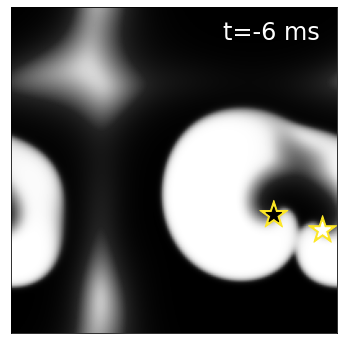

In [511]:
x_values=np.array(x_lst)
y_values=np.array(y_lst)
c_values=0*x_values
c_values[0]=1
# c_values[2]=1
# cmap='bone'
cmap='gray_r'
axis=[0,img.shape[0],0,img.shape[1]]
# message_string=f'{t=:.1f} ms'
message_string=f't=-6 ms'
inch=6;
fontsize=24
vmin_img=0.;vmax_img=1.
vmin_tips=0.;vmax_tips=1.
textcolor='w'
fig, ax = plt.subplots(figsize=(inch,inch))
# ax.imshow(img, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
ax.imshow(img_prev, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
#plot spiral tips. color inner spiral tip by slow variable
ax.scatter(x=x_values, y=y_values, s=870, c=1+0.*c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips)
ax.scatter(x=x_values, y=y_values, s=270, c=c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips, cmap=cmap)
ax.text(.8,.9,message_string,
        horizontalalignment='center',color=textcolor,fontsize=fontsize,
        transform=ax.transAxes)
ax.axis(axis)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [512]:
img_prev = img.copy()
niter = int(np.around(4/DT))
txt = time_evolve_domain_fk_cu(txt,niter,time_step_kernel,drv,printing=False)
img = txt[...,0].copy()

In [513]:
#compute spiral tip number
dict_out=compute_all_spiral_tips(t,img,img_prev,level1=V_threshold,level2=V_threshold)#,width=width,height=height)
n = dict_out['n']
print(f"{n=}")
x_lst = dict_out['x']
y_lst = dict_out['y']

n=2


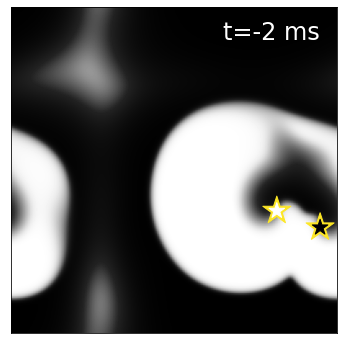

In [514]:
x_values=np.array(x_lst)
y_values=np.array(y_lst)
c_values=0*x_values
c_values[1]=1
# c_values[2]=1
# cmap='bone'
cmap='gray_r'
axis=[0,img.shape[0],0,img.shape[1]]
# message_string=f'{t=:.1f} ms'
message_string=f't=-2 ms'
inch=6;
fontsize=24
vmin_img=0.;vmax_img=1.
vmin_tips=0.;vmax_tips=1.
textcolor='w'
fig, ax = plt.subplots(figsize=(inch,inch))
# ax.imshow(img, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
ax.imshow(img_prev, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
#plot spiral tips. color inner spiral tip by slow variable
ax.scatter(x=x_values, y=y_values, s=870, c=1+0.*c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips)
ax.scatter(x=x_values, y=y_values, s=270, c=c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips, cmap=cmap)
ax.text(.8,.9,message_string,
        horizontalalignment='center',color=textcolor,fontsize=fontsize,
        transform=ax.transAxes)
ax.axis(axis)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# identify a frame just after the creation event

In [515]:
img_prev = img.copy()
niter = int(np.around(4/DT))
txt = time_evolve_domain_fk_cu(txt,niter,time_step_kernel,drv,printing=False)
img = txt[...,0].copy()
#compute spiral tip number
dict_out=compute_all_spiral_tips(t,img,img_prev,level1=V_threshold,level2=V_threshold)#,width=width,height=height)
n = dict_out['n']
print(f"{n=}")
x_lst = dict_out['x']
y_lst = dict_out['y']

n=4


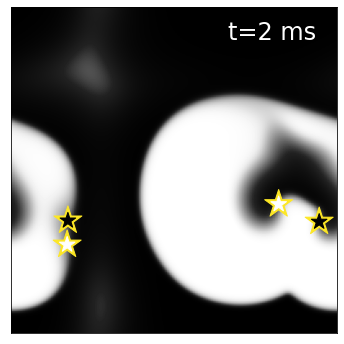

In [520]:
x_values=np.array(x_lst)
y_values=np.array(y_lst)
c_values=0*x_values
c_values[1]=1
c_values[3]=1
# cmap='bone'
cmap='gray_r'
axis=[0,img.shape[0],0,img.shape[1]]
# message_string=f'{t=:.1f} ms'
message_string=f't=2 ms'
inch=6;
fontsize=24
vmin_img=0.;vmax_img=1.
vmin_tips=0.;vmax_tips=1.
textcolor='w'
fig, ax = plt.subplots(figsize=(inch,inch))
# ax.imshow(img, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
ax.imshow(img_prev, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
#plot spiral tips
ax.scatter(x=x_values, y=y_values, s=870, c=1+0.*c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips)
ax.scatter(x=x_values, y=y_values, s=270, c=c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips, cmap=cmap)
ax.text(.8,.9,message_string,
        horizontalalignment='center',color=textcolor,fontsize=fontsize,
        transform=ax.transAxes)
ax.axis(axis)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

n=4


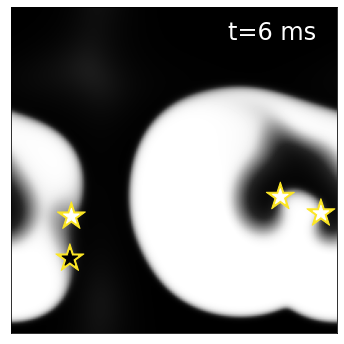

In [521]:
img_prev = img.copy()
niter = int(np.around(4/DT))
txt = time_evolve_domain_fk_cu(txt,niter,time_step_kernel,drv,printing=False)
img = txt[...,0].copy()
#compute spiral tip number
dict_out=compute_all_spiral_tips(t,img,img_prev,level1=V_threshold,level2=V_threshold)#,width=width,height=height)
n = dict_out['n']
print(f"{n=}")
x_lst = dict_out['x']
y_lst = dict_out['y']
x_values=np.array(x_lst)
y_values=np.array(y_lst)
c_values=0*x_values
c_values[0]=1
# c_values[2]=1
# cmap='bone'
cmap='gray_r'
axis=[0,img.shape[0],0,img.shape[1]]
# message_string=f'{t=:.1f} ms'
message_string=f't=6 ms'
inch=6;
fontsize=24
vmin_img=0.;vmax_img=1.
vmin_tips=0.;vmax_tips=1.
textcolor='w'
fig, ax = plt.subplots(figsize=(inch,inch))
# ax.imshow(img, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
ax.imshow(img_prev, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
#plot spiral tips
ax.scatter(x=x_values, y=y_values, s=870, c=1+0.*c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips)
ax.scatter(x=x_values, y=y_values, s=270, c=c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips, cmap=cmap)
ax.text(.8,.9,message_string,
        horizontalalignment='center',color=textcolor,fontsize=fontsize,
        transform=ax.transAxes)
ax.axis(axis)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [522]:
img_prev = img.copy()
niter = int(np.around(4/DT))
txt = time_evolve_domain_fk_cu(txt,niter,time_step_kernel,drv,printing=False)
img = txt[...,0].copy()
#compute spiral tip number
dict_out=compute_all_spiral_tips(t,img,img_prev,level1=V_threshold,level2=V_threshold)#,width=width,height=height)
n = dict_out['n']
print(f"{n=}")
x_lst = dict_out['x']
y_lst = dict_out['y']

n=4


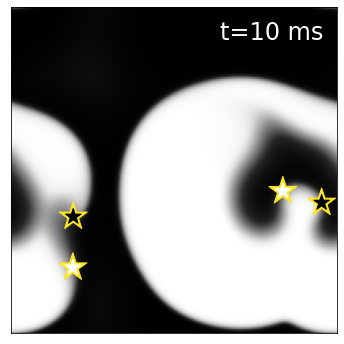

In [526]:
x_values=np.array(x_lst)
y_values=np.array(y_lst)
c_values=0*x_values
c_values[1]=1
c_values[3]=1
# cmap='bone'
cmap='gray_r'
axis=[0,img.shape[0],0,img.shape[1]]
# message_string=f'{t=:.1f} ms'
message_string=f't=10 ms'
inch=6;
fontsize=24
vmin_img=0.;vmax_img=1.
vmin_tips=0.;vmax_tips=1.
textcolor='w'
fig, ax = plt.subplots(figsize=(inch,inch))
# ax.imshow(img, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
ax.imshow(img_prev, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
#plot spiral tips
ax.scatter(x=x_values, y=y_values, s=870, c=1+0.*c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips)
ax.scatter(x=x_values, y=y_values, s=270, c=c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips, cmap=cmap)
ax.text(.8,.9,message_string,
        horizontalalignment='center',color=textcolor,fontsize=fontsize,
        transform=ax.transAxes)
ax.axis(axis)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# scratchwerk

In [100]:

# if dict_out['n']>0:
#     #generation of results
#     # printing=True
#     save_every=67
# #     save_every=22 #~30X slowdown
#     fps=60 #i checked the ffmpeg routine
#     # video_duration=30 #seconds
#     video_duration=15 #seconds
#     pause_after_termination_duration=1. #second
#     accumulated_time_after_termination=0.
#     V_threshold=0.4 #appears best
#     # V_threshold=0.2
#     # V_threshold=0.8
#     # V_threshold=0.95
#     #NOTE: I can make video_duration=30*6 #seconds so long as I am not storing more in ram at a time

#     #define the initial conditions
#     t=tf #ms
#     txt=txt_init.copy()
#     u_initial=txt[...,0].copy()
#     v_initial=txt[...,1].copy()
#     w_initial=txt[...,2].copy()

#     #don't allocate memory many times for the same task!
#     #allocate GPU memory for voltage scalar field
#     u_old = drv.mem_alloc(u_initial.nbytes)
#     u_new = drv.mem_alloc(u_initial.nbytes)
#     #allocate GPU memory for v and w auxiliary fields
#     v_old = drv.mem_alloc(v_initial.nbytes)
#     v_new = drv.mem_alloc(v_initial.nbytes)
#     w_old = drv.mem_alloc(w_initial.nbytes)
#     w_new = drv.mem_alloc(w_initial.nbytes)

#     # explicit time integration up to 5 seconds in steps of size 0.025 ms
#     kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)

#     #setup thread block dimensions and compile the kernel
#     mod = SourceModule(block_size_string+kernel_string)
#     time_step_kernel = mod.get_function("time_step_kernel")

#     # #create events for measuring gpu performance
#     # start_timer = drv.Event()
#     # end_timer = drv.Event()

#     #move the data to the GPU
#     drv.memcpy_htod(u_old, u_initial)
#     drv.memcpy_htod(u_new, u_initial)
#     drv.memcpy_htod(v_old, v_initial)
#     drv.memcpy_htod(v_new, v_initial)
#     drv.memcpy_htod(w_old, w_initial)
#     drv.memcpy_htod(w_new, w_initial)

#     #time evolve txt on gpu saving to cpu once every 67 time steps
#     iterations=save_every
#     number_frames=np.around(video_duration*fps)
#     nsteps=number_frames
#     t_final=tf+DT*iterations*nsteps
#     if printing:
#         print(f"system initialized at time: {t} ms")
#         print(f"saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)")
#         print(f"forward integrating to tf={t_final/1e3} seconds...")
#     dict_out_lst=[]
#     img_lst=[]
#     dimg_dt_lst=[]
#     start = time.time()
#     for step in range(nsteps):
#         #call the GPU kernel 2*iterations times and measure performance
#         context.synchronize()
#         #start_timer.record()
#         for i in range(iterations):
#             time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
#             time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
#         #end_timer.record()
#         context.synchronize()
#         #runtime = end_timer.time_since(start_timer)

#         #copy the result from the GPU to Python for plotting
#         gpu_result_u = np.zeros_like(u_initial)
#         drv.memcpy_dtoh(gpu_result_u, u_old)
#         gpu_result_v = np.zeros_like(v_initial)
#         drv.memcpy_dtoh(gpu_result_v, v_old)
#         gpu_result_w = np.zeros_like(w_initial)
#         drv.memcpy_dtoh(gpu_result_w, w_old)

#         #measure
#         dict_out,img,dimg_dt=measure_system(gpu_result_u,gpu_result_v,gpu_result_w,V_threshold)
#         #update time
#         t=(tf+DT*step*iterations)*0.001 #seconds
#         dict_out['t']=t
#         #record
#         dict_out_lst.append(dict_out)
#         img_lst.append(img)
#         dimg_dt_lst.append(dimg_dt)
#         #update progressbar
#         if printing:
#             n=dict_out['n']
#             printProgressBar(step + 1, nsteps, prefix = f'Progress:', suffix = f'Complete (t={t:.3f} seconds, num. tips:{n})', length = 50)

#         if dict_out['n']==0:
#             #the number of tips is zero
#             accumulated_time_after_termination+=DT*iterations
#             if accumulated_time_after_termination>pause_after_termination_duration:
#                 # break the inner loop
#                 break
#         else:
#             # continue if the inner loop wasn't broken
#             continue
#         # inner loop was broken, break the outer
#         break

#     runtime = time.time() - start
#     if printing:
#         print(f"simulation complete!\ntotal run time: {runtime:.0f} seconds for {ic_fn}.")
#         # beep(1)


In [101]:

#         #generate movie of data currently in virtual memory
#         dump_cache=True
#         save_folder = os.path.join(nb_dir,f'Figures/mov')
#         #dump save_folder if it already exists
#         if not os.path.exists(save_folder):
#             os.mkdir(save_folder)
#         assert (os.path.exists(save_folder))
#         if dump_cache:
#             shutil.rmtree(save_folder)
#             print(f"dumped cache at {save_folder}")
#             os.mkdir(save_folder)

#         task_lst=[]
#         for frameno,(dict_out,img,dimg_dt) in enumerate(zip(dict_out_lst,img_lst,dimg_dt_lst)):
#             save_fn=f"img{frameno:07d}.png"
#             save_dir=os.path.join(save_folder,save_fn)
#             task=dict_out,img,dimg_dt,save_dir
#             task_lst.append(task)
#         task_lst.pop(-1)
#         if printing:
#             print(f"added {len(task_lst)} tasks to task_lst")

#         testing=False
#         if testing:
#             task_index=-100
#             task = task_lst[task_index]
#             routine_to_png_streaming_tips(task)
#             if printing:
#                 print(task[-1])

#         if printing:
#             print(f"NOTA BENE: to check on plotting progess in terminal, go to {save_folder} and enter:\n*** ls | wc -l ***")
#             print (f"estimated run time for plotting ~{6*len(dict_out_lst)/npartitions/60:.1f} minutes...")
#             print  ("estimated run time ~ 1 hour per trial... mpl isn't parallelizing right...")
#             #as is, it's about a 5X undertime...  this suggests 16*5/60 hours is roughly the expected run time

#         # # DONE: make the stream plot with this particle current, as before, but only where there are particles
#         # #     - option 0: ignore the following details and just do what I already did.
#         # #     - option 1: add streams with periodic boundary conditions (only if easy fix found on stackoverflow!)
#         # #     - option 2: add streams on the interior only
#         # #DONE: save ^that to .png with zero borders, as before
#         # #DONE: wrap ^that into a viewer routine_to_png(task)
#         # #TODO: eval_viewer_cluster
#         #this took 1 hour for 1 trial
#         start=time.time()
#         if printing:
#             print(f"generating {len(task_lst)} .png files over {npartitions} cores...")
#         retval=eval_viewer_cluster(task_lst=task_lst,routine_to_png=routine_to_png_streaming_tips,npartitions=npartitions,printing=False)
#         if printing:
#             print(f"the apparent run time for plotting was {(time.time()-start)/60:.1f} minutes")
#         #beep(2)
#         #NOTE: the following was much slower
#         # #concatenate the folder of png files to a video
#         # os.chdir(f"{nb_dir}/../vid/src")
#         # !./concat_folder_png.sh
#         # if printing:
#         #     print(f"V_threshold={V_threshold}")
#         # beep(3)
#         #concatenate the folder of png files to a video
#         os.chdir(f"{nb_dir}/../vid/src")
#         os.system("./concat_folder_png.sh");
#         #copy output movie to a file uniquely named for this recording session
#         # fn=ic_fn
#         fn=os.path.basename(ic_dir)
#         use_streamplot=True
# #         use_streamplot=False
#         if use_streamplot:
#             save_mov_fn=fn.replace('.npz','_streaming_tips.mov')
#             os.chdir(f"{nb_dir}/../vid/mov")
#             folder=f'streaming_tips_fenton_karma_diffCoef_{diffCoef}'
#         else:
#             save_mov_fn=fn.replace('.npz','.mov')
#             os.chdir(f"{nb_dir}/../vid/mov")
#             folder=f'fenton_karma_diffCoef_{diffCoef}'
#         if not os.path.exists(folder):
#             os.mkdir(folder)
#         os.system(f"cp out.mov {os.path.join(folder,save_mov_fn)}")
#         if printing:
#             print(f"{os.path.abspath(save_mov_fn)}")
#         #save dict_out_lst to .pkl in new folder in Data/
#         save_pkl_folder=os.path.join(ic_folder,'..',folder)
#         if not os.path.exists(save_pkl_folder):
#             os.mkdir(save_pkl_folder)
#         save_pkl_fn=fn.replace('.npz','.pkl')
#         save_pkl_dir=os.path.join(save_pkl_folder,save_pkl_fn)
#         save_to_pkl(save_pkl_dir,dict_out_lst)
#         print(f"save_pkl_dir='{save_pkl_dir}'")